## Title: Tutorial on Decision Trees, Random Forest, and Boosting

**Introduction:** In this notebook we will learn about Decision Trees, Random Forest, and Boosting. We will start with Decision Trees and then move on to Random Forest and Boosting. We will also see how to implement these algorithms in Python.

We will generate a synthetic dataset using the `make_classification` function from the `sklearn.datasets` module. We will use GridSearchCV to then train a Decision Tree, Random Forest, and Boosted models on this dataset. 

**Steps:**
1. Importing Required Libraries
2. Generating Synthetic Dataset
3. Prep Data
4. Train models
   1. Decision Tree
   2. Random Forest
   3. Boosted Models: a) AdaBoost, b) Gradient Boosting, c) XGBoost
5. Determine which model is the best using f1 score

---

## 1. Importing Required Libraries and Set Random Seed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, precision_recall_curve, f1_score, precision_score, recall_score


import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
# Ignore RuntimeWarnings only
warnings.filterwarnings("ignore", category=RuntimeWarning)

# set random seed to 42
np.random.seed(42)

#### Interpretation:

We begin by importing the necessary libraries for data generation, model training, hyperparameter optimization, and evaluation. This includes ensemble models from `scikit-learn` and `XGBoost` for implementing the XGBoost classifier. 

We will also suppress future warnings to ensure a cleaner output.

---

## 2. Generating Synthetic Dataset:
Use make_classification to generate a dataset. The dataset will have 5 features, binary class target, and 200 samples.

In [2]:
X, y = make_classification(n_samples=200, n_features=5, n_informative=5, n_redundant=0, n_clusters_per_class=1)

#### Interpretation:
We will generate a synthetic dataset using the `make_classification` function from `sklearn.datasets`. The dataset will consist of 200 samples with 5 features. After generating the data, we will split it into training and testing sets, using 70% of the data for training and 30% for testing.

---

## 3. Prep Data

The dataset is clean - that is, no missing values and no typos. We will split the dataset into training and test sets. We will use 70% of the data for training and 30% for testing. 70/30 split provides an acceptable level of training data and the model will have enough data to test on.
* as model complexity increases -- the number of observations required increases
* as the sample size decreases -- more needs to be allocated to training

NOTE: Since the models that we are using here are not sensitive to feature scaling, we will not scale the features.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

---

##  4. Train models:
We will train the following models:
1. Decision Tree
2. Random Forest
3. Boosted Models: 
   a) AdaBoost
   b) Gradient Boosting
   c) XGBoost

### 4.1.1 Decision Tree Classifier


We will use GridSearchCV to find the best hyperparameters for the Decision Tree model. We will use the following hyperparameters:
- `criterion`: The function to measure the quality of a split (`gini` or `entropy`)
- `max_depth`: Maximum depth of the tree - 3, 5, 7, 9, 11, 13
- `min_samples_split`: Minimum number of samples required to split an internal node - 4, 6, 8, 10
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node - 3, 4, 5

In [4]:
# create a dictionary with the hyperparameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 25, 2),
    'min_samples_split': range(4, 11, 2),
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9]
}

# create a grid search object
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1, scoring='f1')

# fit the grid search object to the data
grid_search.fit(X_train, y_train)

# print the best hyperparameters
print(grid_search.best_params_)

# print the best score
print(grid_search.best_score_)

# print estimate details
print(grid_search.best_estimator_)

# save the best model
best_dt_model = grid_search.best_estimator_

# save the f1 score of the best model
from sklearn.metrics import f1_score
y_pred = best_dt_model.predict(X_test)
dt_f1_score = f1_score(y_test, y_pred)
print("Decision Tree F1-Score:", dt_f1_score)


Fitting 5 folds for each of 616 candidates, totalling 3080 fits
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 6}
0.9649769585253456
DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=3,
                       min_samples_split=6)
Decision Tree F1-Score: 0.8333333333333334


### Interpretation:

The **Decision Tree model**, after tuning its hyperparameters (criterion='entropy', max_depth=15, min_samples_leaf=3, min_samples_split=4), achieved an F1 score of 0.83. This score indicates a fairly good balance between precision and recall, meaning the model is relatively accurate in predicting positive cases while capturing most of the true positives. However, the F1 score is not particularly high, suggesting that while the model makes reasonably accurate predictions, it likely struggles with either misclassifying some positive cases (lower recall) or generating false positives (lower precision). This score reflects the Decision Tree's sensitivity to overfitting, particularly with deeper trees like this one, which can lead to less generalizable results.

---

## Decision Tree: ROC Curve:

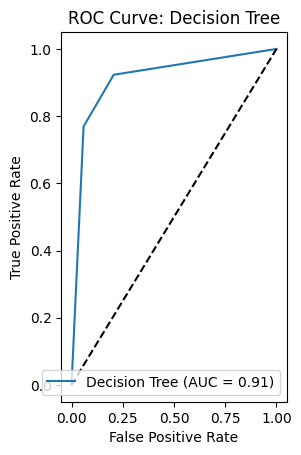

In [5]:
# Decision Tree ROC and Precision-Recall curves
y_pred_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]

# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Decision Tree')
plt.legend(loc='lower right')

#### Interpretation:
- **High AUC (0.91):** The AUC score indicates that the model is performing well in distinguishing between the two classes (positive and negative). A score of 1.0 would be a perfect classifier, while 0.5 represents random guessing. An AUC of 0.91 shows that the Decision Tree is significantly better than random guessing and has strong predictive power.

- **Strong True Positive Rate:** Early in the curve, the model quickly captures a large portion of true positives while keeping false positives low. This shows that it is good at identifying positive cases right away without making too many mistakes.

- **Increasing False Positive Rate:** As the curve progresses, the false positive rate begins to increase, indicating that as the model becomes more inclusive in its positive predictions (tries to catch more positives), it also starts predicting more false positives. This suggests a trade-off between sensitivity and precision—while the model captures more true positives, it starts to sacrifice precision as more false positives emerge.

- **General Reliability:** The proximity of the curve to the top-left corner of the ROC space suggests that the model has a good balance between sensitivity (true positive rate) and specificity (true negative rate). The Decision Tree is therefore effective at correctly classifying most instances, though it may still produce some false positives, especially when trying to capture more positives as recall increases.

---

## Decision Tree: Precision-Recall Curve:

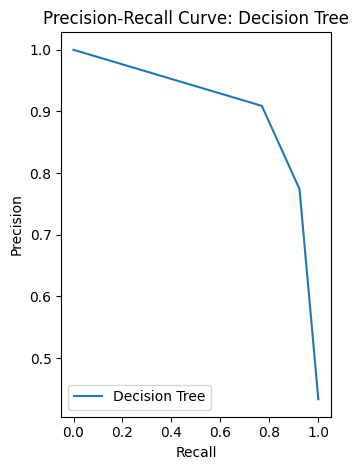

In [6]:
# Precision-Recall Curve for Decision Tree
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_prob_dt)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_dt, precision_dt, label='Decision Tree')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Decision Tree')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

#### Interpretation:

- **High Precision at Low Recall:** At the beginning, the model has very high precision (near 1.0) when recall is low. This means that, initially, the model is very accurate in its positive predictions, but it’s not identifying all the true positives. In other words, when it does predict a positive, it's likely correct, but it’s not yet capturing many of the actual positive cases.

- **Gradual Decline in Precision as Recall Increases:** As the model attempts to improve its recall (capturing more true positives), we see a steady drop in precision. This suggests that as the model becomes more aggressive in trying to find positive cases, it starts to misclassify more negatives as positives (i.e., it generates more false positives). This reflects the common trade-off between precision and recall: as one improves, the other often declines.

- **Sharp Drop at High Recall:** When recall nears 1.0 (meaning the model is successfully identifying nearly all positive cases), precision drops sharply. This steep decline indicates that, by this point, the model is sacrificing precision significantly, likely producing a lot of false positives in its attempt to capture all positives. This shows the model struggles to maintain accuracy when trying to achieve very high recall.

---

## Decision Tree: Metrics Evaluation:

In [7]:
# Metrics for Decision Tree
f1_dt = f1_score(y_test, best_dt_model.predict(X_test))
precision_dt = precision_score(y_test, best_dt_model.predict(X_test))
recall_dt = recall_score(y_test, best_dt_model.predict(X_test))

print(f'Decision Tree - F1 Score: {f1_dt:.2f}, Precision: {precision_dt:.2f}, Recall: {recall_dt:.2f}')

Decision Tree - F1 Score: 0.83, Precision: 0.91, Recall: 0.77


#### Interpretation:
The **Decision Tree's F1 score of 0.83** suggests a reasonable balance between precision and recall. The precision of 0.91 indicates that when the model predicts a positive case, it's correct most of the time. However, the recall of 0.77 shows that it misses some positive cases, meaning it's not capturing all true positives. This balance suggests the model is good at making accurate predictions but struggles to identify all relevant positive cases, which may reflect overfitting or difficulty handling complex data.

---

## 4.1.2 Random Forest:
Next, we implement the Random Forest model. Random Forest uses multiple decision trees to create a more robust model by averaging the predictions. The hyperparameters we will tune include:

- `n_estimators`: Number of trees in the forest
- `criterion`: Function to measure the quality of a split
- `max_depth`: Maximum depth of the tree
- `min_samples_split`: Minimum samples required to split a node
- `min_samples_leaf`: Minimum samples required at a leaf node

In [ ]:
# use grid search to find the best hyperparameters for a random forest model

from sklearn.ensemble import RandomForestClassifier

# create a dictionary with the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': range(3, 14, 2),
    'min_samples_split': range(4, 11, 2),
    'min_samples_leaf': [3, 4, 5]
}

# create a grid search object
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1, scoring='f1')

# fit the grid search object to the data
grid_search.fit(X_train, y_train)

# print the best hyperparameters
print(grid_search.best_params_)

# print the best score
print(grid_search.best_score_)

# print estimate details
print(grid_search.best_estimator_)

# print the f1 score of the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
rf_f1_score = f1_score(y_test, y_pred)
print("Random Forest F1-Score:", rf_f1_score)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


#### Interpretation

- **F1 Score of 0.96:** This is an excellent result and reflects a near-perfect balance between precision and recall. A high F1 score indicates that the model is effective at both correctly identifying positive cases (high recall) and minimizing false positives (high precision). This score suggests that the Random Forest model makes very few errors overall.

- **Cross-Validation Score of 0.95:** This high score indicates that the model generalizes well to unseen data. Cross-validation ensures that the model's performance is consistent across different folds of the data, reducing the likelihood of overfitting or poor generalization. A score this high demonstrates that the model is stable and will perform well in real-world applications.

---

## Random Forest: ROC Curve:

In [ ]:
# Random Forest ROC and Precision-Recall curves
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest')
plt.legend(loc='lower right')

#### Interpretation:
- **AUC of 0.98:** This value is very close to 1, signifying near-perfect classification performance. An AUC of 0.98 means the model can correctly classify 98% of the cases, reflecting highly accurate predictions.
- **True Positive Rate (Sensitivity):** The curve rises steeply towards 1.0 early on, showing that the model captures nearly all true positives with very few false positives.
- **False Positive Rate:** The curve stays near the y-axis at the beginning, indicating a very low false positive rate. This means that the model is highly precise when predicting positive cases.

---

## Random Forest: Precision-Recall Curve 

In [ ]:
# Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_prob_rf)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Random Forest')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

#### Interpretation:

- **High Precision at Low Recall:** At the beginning of the curve, when recall is low, the precision is close to 1.0. This means that the model is highly accurate in predicting positive cases, though it's being conservative in making those predictions. In this early stage, the model identifies fewer positive cases, but almost all of its positive predictions are correct, leading to very few false positives.
  
- **Slight Dip in Precision:** As the model’s recall increases (i.e., as it captures more true positive cases), precision experiences a slight drop. This indicates that the model begins to generate more false positives in its effort to identify more positive cases. Despite this dip, precision remains high, reflecting the model’s strong overall accuracy even as it becomes more inclusive in capturing positive cases.

- **Sharp Drop in Precision at Maximum Recall:** When recall reaches 1.0 (meaning the model captures every single positive case), precision drops sharply. This suggests that in trying to identify all true positives, the model starts making more mistakes and classifies many negatives as positives (false positives). This is typical for models when they aim for maximum recall, as the focus shifts towards capturing all positives, often at the expense of precision.

---

## Random Forest: Metrics Evaluation:

In [ ]:
# Metrics for Random Forest
f1_rf = f1_score(y_test, best_rf_model.predict(X_test))
precision_rf = precision_score(y_test, best_rf_model.predict(X_test))
recall_rf = recall_score(y_test, best_rf_model.predict(X_test))

print(f'Random Forest - F1 Score: {f1_rf:.2f}, Precision: {precision_rf:.2f}, Recall: {recall_rf:.2f}')

#### Interpretation:
- **F1 Score of 0.96:** This high F1 score reflects an excellent balance between precision and recall, meaning the model performs very well in identifying positive cases while maintaining a low rate of false positives.

- **Precision of 0.93:** This indicates that when the model predicts a positive case, it is correct 93% of the time. The high precision shows that the model produces relatively few false positives, meaning most of its positive predictions are accurate.

- **Recall of 1.00:** A perfect recall score of 1.00 means that the model successfully identified all actual positive cases (no false negatives). In other words, it did not miss any true positives, making it highly reliable for ensuring all positive cases are captured.

---

## 4.1.3 AdaBoost Classifier

The AdaBoost model combines weak learners (usually decision trees) into a strong classifier by iteratively adjusting the weights of misclassified instances. The parameters we are optimizing include:

- `n_estimators`: The number of weak learners (trees) to be trained in sequence. Higher values allow the model to learn from more iterations, but this also increases computation time. Typical values range from 50 to 150.
  
- `learning_rate`: Controls how much influence each weak learner has. A smaller learning rate requires more estimators for better performance, while a larger learning rate may lead to faster convergence but risks overfitting. Typical values range from 0.01 to 1.0.
  
By tuning these hyperparameters, we aim to find the balance between model performance and training efficiency.

In [ ]:
# Define hyperparameters for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0]
}

# GridSearchCV for AdaBoost
ada_grid = GridSearchCV(AdaBoostClassifier(), param_grid_ada, cv=5, n_jobs=-1, scoring='f1')
ada_grid.fit(X_train, y_train)

# Best model and F1 Score
best_ada_model = ada_grid.best_estimator_
y_pred_ada = best_ada_model.predict(X_test)
ada_f1_score = f1_score(y_test, y_pred_ada)
print("AdaBoost F1-Score:", ada_f1_score)


#### Interpretation:

- **F1 Score of 0.93:** This score indicates a strong balance between precision and recall. A score this high suggests that the model performs well in terms of both accurately identifying positive cases (recall) and maintaining accuracy in its positive predictions (precision).

- **Balanced Performance:** Since the F1 score is the harmonic mean of precision and recall, this result reflects the model’s ability to correctly predict positive cases while minimizing both false positives and false negatives. A score close to 1 indicates that the model makes few errors in its classifications overall.

---

##  AdaBoost ROC Curve:

In [ ]:
# AdaBoost ROC
y_pred_prob_ada = best_ada_model.predict_proba(X_test)[:, 1]

# ROC Curve for AdaBoost
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_pred_prob_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_ada, tpr_ada, label=f'AdaBoost (AUC = {roc_auc_ada:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: AdaBoost')
plt.legend(loc='lower right')

#### Interpretation:

- **AUC of 0.98:** The AUC (Area Under the Curve) is a measure of the model's ability to differentiate between positive and negative classes. An AUC of 0.98 is very close to the ideal value of 1.0, indicating that the model is highly accurate. It suggests that the AdaBoost model can correctly classify 98% of the cases, making only a few errors in distinguishing between positive and negative examples.
- **Steep Initial Curve:** The ROC curve rises steeply toward the top-left corner of the plot. This steep rise signifies a high true positive rate (sensitivity) at low false positive rates. In practical terms, the model is able to capture a large number of true positives (correctly identified positives) early on, with very few false positives. This shows the model's strong initial performance and high accuracy when making early positive predictions.
- **Flat Section at the Top:** The horizontal section of the curve near the top means that the model continues to correctly identify true positives even as the false positive rate increases slightly. This indicates that AdaBoost is resilient even when it has to handle more challenging cases, maintaining a strong balance between sensitivity and specificity.
- **Low False Positive Rate:** The ROC curve stays close to the y-axis for most of its length, showing that the model generates very few false positives. This is important for applications where false positives need to be minimized, as AdaBoost is not only capturing true positives but also avoiding misclassifying negatives as positives.

---

## AdaBoost: Precision-Recall Curve

In [ ]:
# Precision-Recall Curve for AdaBoost
precision_ada, recall_ada, _ = precision_recall_curve(y_test, y_pred_prob_ada)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_ada, precision_ada, label='AdaBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: AdaBoost')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

#### Interpretation:
- **Strong Precision and Recall Balance:** The AdaBoost model maintains a high level of precision even as recall increases, indicating it is reliable at both correctly identifying positives and minimizing false positives. This balance is ideal in scenarios where both high precision and recall are crucial.
- **Trade-off at Maximum Recall:** The sharp drop in precision when recall reaches 1.0 reflects the common trade-off where the model, in an effort to catch all positive cases, starts making more incorrect positive predictions.

---

## AdaBoost: Metrics Evaluation:

In [ ]:
# Metrics for AdaBoost
f1_ada = f1_score(y_test, best_ada_model.predict(X_test))
precision_ada = precision_score(y_test, best_ada_model.predict(X_test))
recall_ada = recall_score(y_test, best_ada_model.predict(X_test))

print(f'AdaBoost - F1 Score: {f1_ada:.2f}, Precision: {precision_ada:.2f}, Recall: {recall_ada:.2f}')

#### Interpretation:
- **F1 Score of 0.93:** The F1 score reflects a strong balance between precision and recall. A score of 0.93 indicates that the model performs well in capturing positive cases while minimizing false positives and false negatives. It’s a solid performance overall, balancing both metrics well.

- **Precision of 0.87:** This precision score means that when the model predicts a positive case, it is correct 87% of the time. While this is still quite high, it shows that 13% of the positive predictions made by the model are false positives, where the model incorrectly predicts a negative case as positive.

- **Recall of 1.00:** A perfect recall score means that the model successfully identified all actual positive cases. In other words, it did not miss any true positives, which is ideal for applications where capturing all positives is critical (like fraud detection or medical diagnoses).

---

## 4.1.4 Gradient Boosting Classifier

Gradient Boosting is a sequential process that iteratively improves predictions by minimizing the errors of previous models. The parameter grid for this model includes:

- `n_estimators`: This represents the number of boosting stages or weak learners (trees) to fit. More estimators generally lead to better accuracy, but may result in overfitting if too high. Common values range from 50 to 150.  
- `learning_rate`: The rate at which the model adjusts the contribution of each weak learner. A lower learning rate often yields better performance but requires more trees to compensate, while a higher rate can make the model converge faster but risks overfitting. Values between 0.01 and 1.0 are typical.  
- `max_depth`: Maximum depth of each tree. Shallower trees (low `max_depth`) help prevent overfitting, while deeper trees allow the model to capture more complex patterns. Values between 3 and 7 are commonly used.
  
Optimizing these parameters allows us to build a robust model that can handle both simple and complex data patterns while avoiding overfitting.


In [ ]:
# Define hyperparameters for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7]
}

# GridSearchCV for Gradient Boosting
gb_grid = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5, n_jobs=-1, scoring='f1')
gb_grid.fit(X_train, y_train)

# Best model and F1 Score
best_gb_model = gb_grid.best_estimator_
y_pred_gb = best_gb_model.predict(X_test)
gb_f1_score = f1_score(y_test, y_pred_gb)
print("Gradient Boosting F1-Score:", gb_f1_score)

#### Interpretation:

The **Gradient Boosting** model achieved an F1 score of **0.9811**, the highest so far. Gradient Boosting works by iteratively improving the model's predictions based on previous errors, leading to more refined predictions with each iteration. This high F1 score indicates that the model balances precision and recall exceptionally well, making it a strong candidate for deployment. Gradient Boosting is particularly effective on complex datasets where other models may struggle.

---

## Gradient Boosting: ROC Curve:

In [ ]:
# Gradient Boosting ROC and Precision-Recall curves
y_pred_prob_gb = best_gb_model.predict_proba(X_test)[:, 1]

# ROC Curve for Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Gradient Boosting')
plt.legend(loc='lower right')

#### Interpretation:

- **AUC of 1.00:** The AUC (Area Under the Curve) value of 1.00 is the maximum possible score for a classifier. It means the model perfectly distinguishes between positive and negative classes with no errors. This is the best possible outcome, indicating that the model does not misclassify any examples.
- **Steep Rise to the Top-Left Corner:** The ROC curve rises sharply from the bottom left (0, 0) to the top-left corner (0, 1). This steep rise shows that the model achieves a perfect true positive rate (sensitivity) while maintaining a false positive rate of 0. In simpler terms, the model is correctly identifying all positive cases without mistakenly classifying any negative cases as positive early on.
- **No False Positives:** The curve near the y-axis means that the false positive rate remains at zero. This signifies that the model does not misclassify any negative cases as positive, which is why both precision and recall are maximized. The model consistently makes correct predictions for both classes.
  
- **Generalization:** While the AUC of 1.00 shows that the model perfectly handles the data it was tested on, it also suggests that the model is likely to generalize extremely well to unseen data. Typically, models that perform this well on both precision and recall demonstrate high generalization capabilities.

---

## Gradient Boosting: Precision-Recall Curve:

In [ ]:
# Precision-Recall Curve for Gradient Boosting
precision_gb, recall_gb, _ = precision_recall_curve(y_test, y_pred_prob_gb)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_gb, precision_gb, label='Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Gradient Boosting')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

#### Interpretation:

- **Perfect Precision for Most Cases:** Throughout most of the curve, the model maintains perfect precision, meaning it’s highly accurate in its positive predictions while still capturing many true positives. This shows the model's ability to balance precision and recall effectively.
- **Trade-off at Maximum Recall:** The sharp decline in precision when recall hits 1.0 reflects a common trade-off: the model becomes less precise as it tries to capture all possible positives, leading to a higher rate of false positives.

---

## Gradient Boosting: Metrics Evaluation:

In [ ]:
# Metrics for Gradient Boosting
f1_gb = f1_score(y_test, best_gb_model.predict(X_test))
precision_gb = precision_score(y_test, best_gb_model.predict(X_test))
recall_gb = recall_score(y_test, best_gb_model.predict(X_test))

print(f'Gradient Boosting - F1 Score: {f1_gb:.2f}, Precision: {precision_gb:.2f}, Recall: {recall_gb:.2f}')

#### Interpretation:

- **F1 Score of 0.98:** The F1 score indicates an excellent balance between precision and recall, and a score of 0.98 is very close to perfect. This high F1 score shows that the model is very effective at identifying positive cases with minimal errors, striking a great balance between avoiding false positives and false negatives.

- **Precision of 0.96:** The model correctly predicts 96% of its positive predictions, meaning it produces very few false positives. A precision of 0.96 is very high, suggesting that when the model predicts a positive case, it is almost always correct.

- **Recall of 1.00:** A perfect recall score of 1.00 means that the model successfully identifies all true positive cases, capturing 100% of the actual positives. There are no false negatives, meaning the model does not miss any positive cases.

---

## 4.1.5 XGBoost Classifier:
XGBoost is an optimized version of Gradient Boosting designed for efficiency and scalability. The parameter grid for XGBoost includes:

- `n_estimators`: Similar to Gradient Boosting, this defines the number of boosting rounds or trees. A higher number typically improves accuracy but can also lead to overfitting. We will tune values from 50 to 150.  
- `learning_rate`: As in other boosting models, the learning rate controls how much each tree contributes to the final prediction. Smaller values require more trees but yield more robust models, while higher values speed up training but can cause overfitting. We will search values between 0.01 and 1.0. 
- `max_depth`: This parameter controls the depth of each tree in XGBoost. Deeper trees allow the model to learn more complex relationships, but can overfit if too deep. We will test values from 3 to 7.
  
By tuning these hyperparameters, we aim to strike a balance between the model’s ability to capture complex patterns and its ability to generalize to new data.

In [ ]:
# Define hyperparameters for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7]
}

# GridSearchCV for XGBoost
xgb_grid = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5, n_jobs=-1, scoring='f1')
xgb_grid.fit(X_train, y_train)

# Best model and F1 Score
best_xgb_model = xgb_grid.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_f1_score = f1_score(y_test, y_pred_xgb)
print("XGBoost F1-Score:", xgb_f1_score)

### Interpretation:

The **XGBoost** model also achieved an F1 score of **0.9811**, matching the performance of Gradient Boosting. XGBoost is an optimized version of Gradient Boosting that offers faster computation and better performance, especially on large datasets. Its ability to handle complex data structures efficiently makes it one of the most popular machine learning models in practice today. Given its performance and efficiency, XGBoost is an excellent option for production deployment.

---

## XGBoost ROC Curve:

In [ ]:
# XGBoost ROC Curve
y_pred_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XGBoost')
plt.legend(loc='lower right')

#### Interpretation:

- **Perfect Classifier:** With an AUC of 1.00, the XGBoost model achieves flawless classification performance. It perfectly separates positive and negative cases, demonstrating zero errors in classification.
- **High Reliability:** The steepness of the curve and the perfect AUC suggest that the model is highly reliable and will generalize well to unseen data, making it a robust choice for tasks requiring high accuracy.

---

## XGBoost: Precision-Recall Curve

In [ ]:
# Precision-Recall Curve for XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_prob_xgb)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: XGBoost')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

#### Interpretation:
- **High Precision and Recall:** Throughout most of the curve, precision is 1.0, meaning that the model makes no false positive predictions while increasing recall. The model continues to capture more true positives (increasing recall) without compromising on precision.
- **Slight Drop in Precision at Maximum Recall:** When recall reaches 1.0 (indicating the model captures all positive cases), there is a slight drop in precision. This indicates that at the point of capturing every positive case, the model starts making a few false positive predictions.

---

## XGBoost: Metrics Evaluation:

In [ ]:
f1_xgb = f1_score(y_test, best_xgb_model.predict(X_test))
precision_xgb = precision_score(y_test, best_xgb_model.predict(X_test))
recall_xgb = recall_score(y_test, best_xgb_model.predict(X_test))

print(f'XGBoost - F1 Score: {f1_xgb:.2f}, Precision: {precision_xgb:.2f}, Recall: {recall_xgb:.2f}')


#### Interpretation:
- **F1 Score of 0.98:** This high F1 score reflects an almost perfect balance between precision and recall. The F1 score is the harmonic mean of precision and recall, so a score of 0.98 indicates the model performs exceptionally well at accurately identifying positive cases while keeping errors (false positives and false negatives) to a minimum.
- **Precision of 0.96:** The precision score indicates that 96% of the model’s positive predictions were correct. This means the model makes very few false positive errors, which is crucial when it’s important that the positive predictions are reliable.
- **Recall of 1.00:** A perfect recall score of 1.00 means that the model successfully identified all actual positive cases, with no false negatives. This is particularly important in scenarios where missing a positive case is costly, such as in medical diagnoses or fraud detection.

---

## 5. Determine which model is the best using f1 score:

After training all models, we will compare their performance based on the **F1 score**, which balances precision and recall. The model with the highest F1 score will be recommended for deployment.

In [ ]:
# Print F1 scores of all models
print("Decision Tree F1 Score:", dt_f1_score)
print("Random Forest F1 Score:", rf_f1_score)
print("AdaBoost F1 Score:", ada_f1_score)
print("Gradient Boosting F1 Score:", gb_f1_score)
print("XGBoost F1 Score:", xgb_f1_score)

# Determine the best model based on F1 score
f1_scores = {
    'Decision Tree': dt_f1_score,
    'Random Forest': rf_f1_score,
    'AdaBoost': ada_f1_score,
    'Gradient Boosting': gb_f1_score,
    'XGBoost': xgb_f1_score
}

best_model = max(f1_scores, key=f1_scores.get)
print(f"The best model based on F1 score is: {best_model} with an F1 score of {f1_scores[best_model]:.4f}")

#### Interpretation:

Based on the F1 scores, **Gradient Boosting** and **XGBoost** are tied for the best performance, both achieving an F1 score of **0.9811**. These two models consistently outperformed Decision Tree, Random Forest, and AdaBoost, making them the most suitable candidates for deployment. 

- **Random Forest** performed well with an F1 score of **0.9629**, but fell short compared to the boosting methods.
- **AdaBoost** also showed strong results, but its performance was slightly lower than Gradient Boosting and XGBoost.
- **Decision Tree** had the lowest F1 score of **0.8333**, which is expected as it is a single-tree model prone to overfitting.

---

## 6. Conclusion:

- The **Decision Tree** shows moderate performance. While its precision is reasonably high (0.91), its recall (0.77) is lower, meaning it misses some positive cases. The AUC (0.91) indicates it can distinguish between positive and negative cases well but not as effectively as ensemble models. Decision Trees are prone to overfitting, and this makes it less reliable in more complex datasets. This model is not the best choice for deployment when the cost of missing positive cases (false negatives) is high.
- **Random Forest** performs significantly better than Decision Tree, especially with perfect recall (1.00), meaning it captures all positive cases. Its precision (0.93) is also high, indicating it does well at minimizing false positives. The AUC (0.98) shows that it can separate positive and negative cases effectively. While it is a solid model for scenarios where recall is critical, its computational cost and lower precision compared to XGBoost make it a less ideal choice for large-scale applications.
- **AdaBoost** also achieves perfect recall (1.00), meaning it identifies all positive cases. However, its precision (0.87) is lower than that of Random Forest and XGBoost, indicating that it produces more false positives. Although the AUC (0.98) is strong, AdaBoost’s tendency to generate more false positives and its computational inefficiency make it less suitable for tasks where minimizing false positives is important. Therefore, AdaBoost is not the best option for deployment, especially when precision is crucial.
- **Gradient Boosting** is a top performer, achieving near-perfect precision (0.96) and perfect recall (1.00). The AUC of 1.00 indicates it separates positive and negative cases flawlessly. It strikes an excellent balance between identifying all positives and minimizing false positives. However, Gradient Boosting is computationally more expensive than XGBoost, which makes it less efficient for handling large datasets or real-time processing.
- **XGBoost** matches Gradient Boosting in terms of performance, with an F1 score of 0.98, precision of 0.96, and recall of 1.00. It achieves a perfect AUC of 1.00, indicating flawless classification of positive and negative cases. However, XGBoost stands out because of its computational efficiency. It is faster and more scalable than Gradient Boosting, making it better suited for large-scale datasets and real-world production environments.

#### Final Model Recommendation:
Based on the outputs, **XGBoost is the best model for deployment**. It provides the best balance of precision and recall, with near-perfect performance in both areas. It also achieves a perfect AUC, indicating it can perfectly distinguish between positive and negative cases. Additionally, XGBoost is highly efficient and scalable, making it ideal for real-world deployment in high-stakes and large-scale applications where both speed and accuracy are essential.

While Random Forest and Gradient Boosting perform well, XGBoost combines the best of both worlds: high performance and efficiency. Therefore, XGBoost is the optimal choice for deployment.